In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
rm_state = 987654321  # for reproducibility
pd.set_option('display.max_columns', None)  # to see all columns of the dataset

# Data import

In [3]:
df = pd.read_csv('data_client_churn.csv')
df.head(10)

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,NaN,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,NaN,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,NaN,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,NaN,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,NaN,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,NaN,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,NaN,No
8,8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,NaN,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,NaN,Yes
9,9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,NaN,No,No,No,No,One year,No,Bank transfer (automatic),56.15,NaN,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7043 non-null   int64  
 1   customerID        7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   int64  
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      1409 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       5517 non-null   object 
 14  StreamingTV       5517 non-null   object 
 15  StreamingMovies   5517 non-null   object 
 16  Contract          7043 non-null   object 


In [5]:
# Imbalanced dataset
df["Churn"].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

In [6]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [7]:
df.set_index("Unnamed: 0", inplace=True)

# Data exploration

In [8]:
df.isnull().sum()

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
tenure                 0
PhoneService           0
MultipleLines          0
InternetService        0
OnlineSecurity         0
OnlineBackup        5634
DeviceProtection       0
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
Contract               0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges        2113
Churn                  0
dtype: int64

TechSupport, StreamingTV, StreamingMovies, OnlineBackup are for clients with internet service.

In [9]:
df["TechSupport"] = np.where((df["InternetService"] == "No") & (df["TechSupport"].isnull()), "No", df["TechSupport"])
df["StreamingTV"] = np.where((df["InternetService"] == "No") & (df["StreamingTV"].isnull()), "No", df["StreamingTV"])
df["StreamingMovies"] = np.where((df["InternetService"] == "No") & (df["StreamingMovies"].isnull()), "No",
                                 df["StreamingMovies"])
df["OnlineBackup"] = np.where((df["InternetService"] == "No") & (df["OnlineBackup"].isnull()), "No", df["OnlineBackup"])

In [10]:
df.isnull().sum()

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
tenure                 0
PhoneService           0
MultipleLines          0
InternetService        0
OnlineSecurity         0
OnlineBackup        4416
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
Contract               0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges        2113
Churn                  0
dtype: int64

## Categorical Features

In [11]:
columns = df.columns
cat_features = []

for col in columns:
    if df[col].value_counts().shape[0] < 10:
        cat_features.append(col)
cat_features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [12]:
# See churn repartition for each categorical feature
for col in cat_features:
    if col != 'Churn':
        print(df[[col, 'Churn']].groupby(col).mean())

           Churn
gender          
Female  0.269209
Male    0.261603
                  Churn
SeniorCitizen          
0              0.236062
1              0.416813
            Churn
Partner          
No       0.329580
Yes      0.196649
               Churn
Dependents          
No          0.312791
Yes         0.154502
                 Churn
PhoneService          
No            0.249267
Yes           0.267096
                     Churn
MultipleLines             
No                0.250442
No phone service  0.249267
Yes               0.286099
                    Churn
InternetService          
DSL              0.189591
Fiber optic      0.418928
No               0.074050
                        Churn
OnlineSecurity               
No                   0.417667
No internet service  0.074050
Yes                  0.146112
                        Churn
OnlineBackup                 
No                   0.187737
No internet service  0.071429
Yes                  0.191176
                       

In [13]:
# We choose to drop gender (no churn variation between male and female)
# We choose to drop customerID (no predictive power)
to_drop = ['customerID', 'gender']

MultipleLines give more information than PhoneService: if a client has multiple lines, they have phone service. We can drop PhoneService and binarize MultipleLines

In [14]:
df["MultipleLines"] = df["MultipleLines"].replace("No phone service", "No")
print(df[["MultipleLines", 'Churn']].groupby("MultipleLines").mean())
to_drop.append("PhoneService")

                  Churn
MultipleLines          
No             0.250246
Yes            0.286099


## Continuous Features

In [15]:
columns = df.columns
cont_features = []

for col in columns:
    if df[col].value_counts().shape[0] >= 10:
        cont_features.append(col)
cont_features

['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']

Trying to convert TotalCharges to float

In [16]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce', downcast='float')

TotalCharges are the monthly charges multiplied by the age in months of the contract. Let's plot the differences between these features :

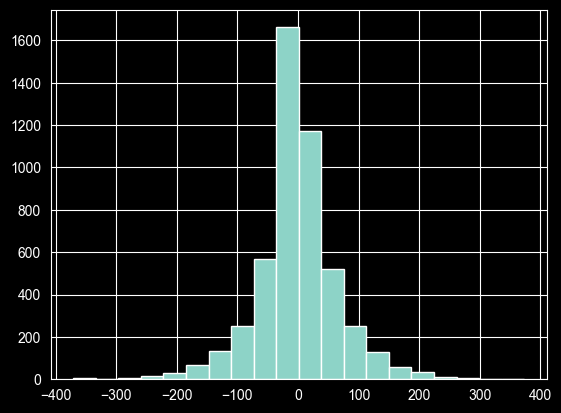

In [17]:
(df["TotalCharges"] - (df["MonthlyCharges"] * df["tenure"])).hist(bins=20)

To reduce information repetition, we choose to drop TotalCharges and keep tenure and MonthlyCharges:

In [18]:
to_drop.append("TotalCharges")

## Feature Selection

Dropping unwanted features

In [19]:
df.drop(columns=to_drop, inplace=True)
cat_features = [col for col in cat_features if col not in to_drop]
cont_features = [col for col in cont_features if col not in to_drop]

### Remaining missing data

In [20]:
df.isnull().sum()

SeniorCitizen          0
Partner                0
Dependents             0
tenure                 0
MultipleLines          0
InternetService        0
OnlineSecurity         0
OnlineBackup        4416
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
Contract               0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
Churn                  0
dtype: int64

In [21]:
# We define two sub-datasets, and we compare their distributions.
df_nob = df[df["OnlineBackup"].isnull()]
df_ob = df[~df["OnlineBackup"].isnull()]

In [22]:
print(df_nob["Churn"].value_counts(normalize=True))
print(df_ob["Churn"].value_counts(normalize=True))

Churn
0    0.680707
1    0.319293
Name: proportion, dtype: float64
Churn
0    0.825276
1    0.174724
Name: proportion, dtype: float64


Churn distribution is significantly different between the two datasets. We decide to fill the missing values by a new value "Unknown."

In [23]:
df["OnlineBackup"] = df["OnlineBackup"].fillna("Unknown")
df["OnlineBackup"].value_counts(normalize=True)

OnlineBackup
Unknown                0.627006
No                     0.261678
Yes                    0.067585
No internet service    0.043731
Name: proportion, dtype: float64

### Binarization One hot encoding

Multiple columns contain the value "No internet service." This information is duplicated with InternetService=No.

In [24]:
df["OnlineSecurity"] = df["OnlineSecurity"].replace("No internet service", "No")
df["OnlineBackup"] = df["OnlineBackup"].replace("No internet service", "No")
df["DeviceProtection"] = df["DeviceProtection"].replace("No internet service", "No")

In [25]:
# One hot encoding of all categorical features except Churn and SeniorCitizen (already binary)
df = pd.get_dummies(df, columns=[c for c in cat_features if c not in ["Churn", "SeniorCitizen"]], drop_first=True,
                    dtype='int')

## Correlation Analysis

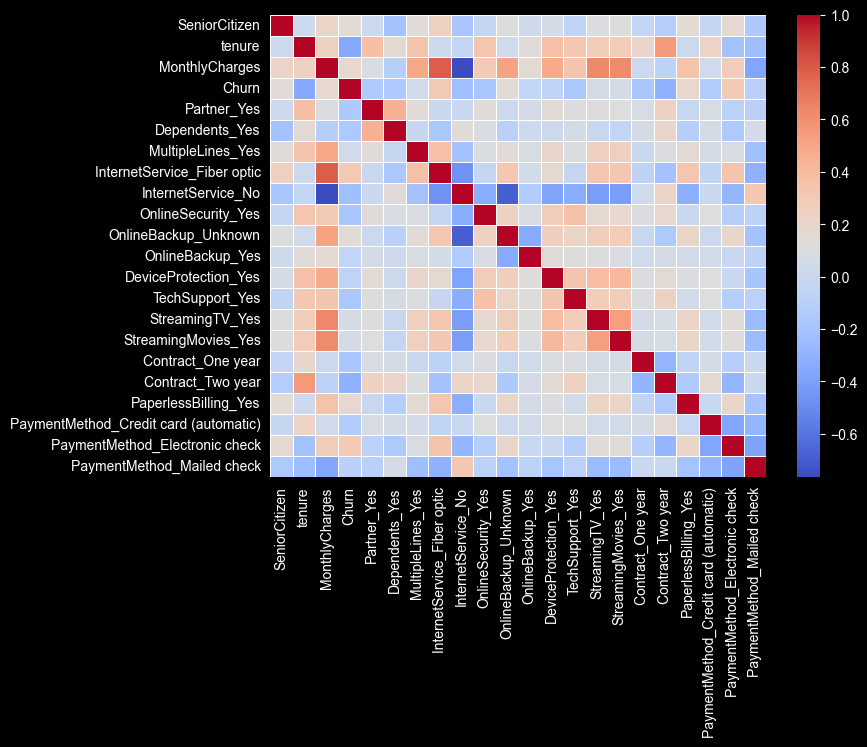

In [26]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

Observations :

1. MonthlyCharges are correlated with the presence of options on the contract, like fiber opticStreaming Movies ...
2. Tenure is correlated with Contract modality (1 year or 2 years) (logical)
3. Clients without internet service are correlated with the absence of options requiring internet (logical)

In [27]:
# Fiber optic contracts are approximately twice as expensive as other contracts on average :
df[["InternetService_Fiber optic", "MonthlyCharges"]].groupby("InternetService_Fiber optic").mean()

,MonthlyCharges
InternetService_Fiber optic,
0,43.788244
1,91.500129


In [28]:
# Similarly, contracts with no Internet Services are cheaper than other contracts on average :
df[["InternetService_No", "MonthlyCharges"]].groupby("InternetService_No").mean()

,MonthlyCharges
InternetService_No,
0,76.844254
1,21.079194


In [29]:
# Most correlated features to Churn
correlation_matrix["Churn"].sort_values(ascending=False)[:10]

Churn                             1.000000
InternetService_Fiber optic       0.308020
PaymentMethod_Electronic check    0.301919
MonthlyCharges                    0.193356
PaperlessBilling_Yes              0.191825
OnlineBackup_Unknown              0.158345
SeniorCitizen                     0.150889
StreamingTV_Yes                   0.063228
StreamingMovies_Yes               0.061382
MultipleLines_Yes                 0.040102
Name: Churn, dtype: float64

In [30]:
# Least correlated features to Churn
correlation_matrix["Churn"].sort_values(ascending=True)[:10]

tenure                                  -0.352229
Contract_Two year                       -0.302253
InternetService_No                      -0.227890
Contract_One year                       -0.177820
OnlineSecurity_Yes                      -0.171226
TechSupport_Yes                         -0.164674
Dependents_Yes                          -0.164221
Partner_Yes                             -0.150448
PaymentMethod_Credit card (automatic)   -0.134302
PaymentMethod_Mailed check              -0.091683
Name: Churn, dtype: float64

Churn is correlated with :
- Fibre optic (expensive)
- Electronic check
- Monthly charges (higher prices encourage churn)
- Paperless Billing

Client fidelity is correlated with :
- Tenure (logical)
- Contract 2 years and 1 year (longer contracts modalities are less likely to churn)
- No internet service (cheaper)

# Churn Prediction

## Data scaling

In [31]:
Y = df["Churn"]
X = df.drop(columns=["Churn"])

In [32]:
# We use "stratify" for class imbalance
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=rm_state, shuffle=True,
                                                    stratify=Y)

In [33]:
# Scaling separately train and test set to avoid data leakage
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Logistic Regression

In [34]:
# We use "class_weight" for class imbalance
model_lr = LogisticRegression(random_state=rm_state, class_weight="balanced")
model_lr.fit(X_train_scaled, Y_train)
y_pred_train = model_lr.predict(X_train_scaled)
y_pred = model_lr.predict(X_test_scaled)

In [35]:
print(f"Performance on train set : \n {classification_report(Y_train, y_pred_train)}")
print(f"Performance on test set : \n {classification_report(Y_test, y_pred)}")

Performance on train set : 
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      4139
           1       0.52      0.81      0.63      1495

    accuracy                           0.75      5634
   macro avg       0.72      0.77      0.72      5634
weighted avg       0.81      0.75      0.76      5634

Performance on test set : 
               precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



Similar performance on train and test sets: no overfitting

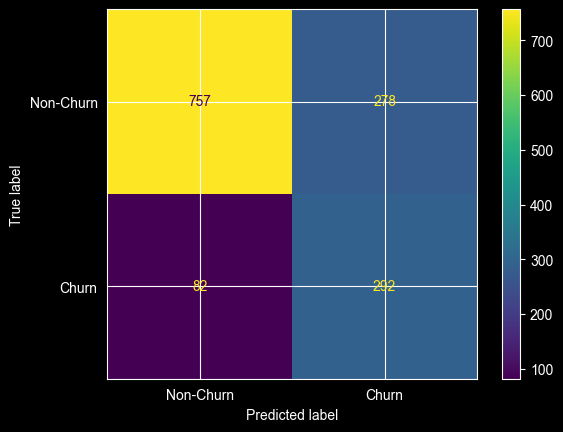

In [36]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, y_pred), display_labels=["Non-Churn", "Churn"]).plot()
plt.show()

- Good recall: the model misses a few client churns
- Mediocre precision: if a client churn is predicted, half of the time the client will not churn

In [37]:
y_scores_lr = model_lr.predict_proba(X_test_scaled)[:, 1]
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(Y_test, y_scores_lr)

### Feature Importance

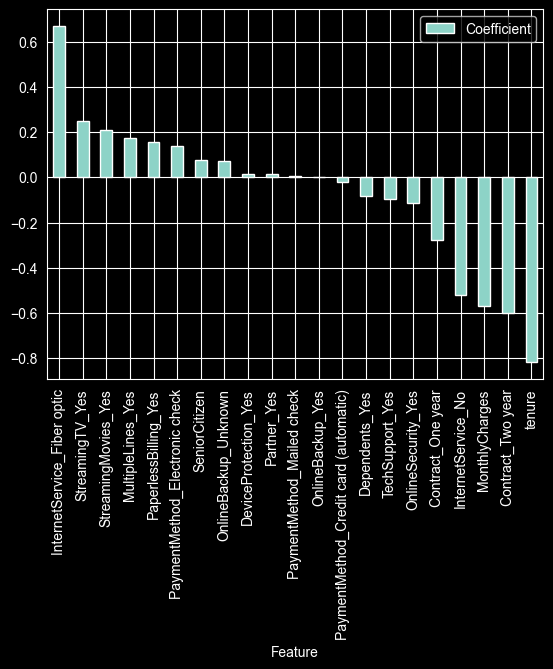

In [38]:
# Get importance features
coefficients = model_lr.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
})
print("\nFeature Importance:")
feature_importance.sort_values(by='Coefficient', ascending=False).plot.bar(x="Feature", y="Coefficient")

Feature importance is consistent with correlation analysis: features rising price subscription positively impact the churn, while long-term contract modality and tenure negatively impact churn.

## Random Forest

In [39]:
rf = RandomForestClassifier(n_estimators=100, random_state=rm_state, class_weight="balanced")
rf.fit(X_train, Y_train)
y_pred_train = rf.predict(X_train)
y_pred = rf.predict(X_test)

In [40]:
print(f"Performance on train set : \n {classification_report(Y_train, y_pred_train)}")
print(f"Performance on test set : \n {classification_report(Y_test, y_pred)}")

Performance on train set : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4139
           1       0.99      1.00      0.99      1495

    accuracy                           1.00      5634
   macro avg       0.99      1.00      1.00      5634
weighted avg       1.00      1.00      1.00      5634

Performance on test set : 
               precision    recall  f1-score   support

           0       0.82      0.89      0.85      1035
           1       0.60      0.46      0.52       374

    accuracy                           0.77      1409
   macro avg       0.71      0.67      0.68      1409
weighted avg       0.76      0.77      0.76      1409



The model overfit. Time to reduce model complexity. Let's tune hyperparameters. Recall is the most important metric here, we don't want to ignore client churn. Precision is important but less.

In [41]:
parameters = {'max_depth': [5, 10, 15, 20], 'n_estimators': [50, 77, 100, 125, 150]}
best_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=rm_state, class_weight="balanced"),
                       param_grid=parameters, n_jobs=-1, scoring="f1", cv=5)
best_rf.fit(X_train, Y_train)

print(best_rf.best_params_)
print(best_rf.best_score_)

{'max_depth': 10, 'n_estimators': 50}
0.6273536783407021


In [42]:
y_pred = best_rf.predict(X_test)
y_pred_train = best_rf.predict(X_train)

In [43]:
print(f"Performance on train set : \n {classification_report(Y_train, y_pred_train)}")
print(f"Performance on test set : \n {classification_report(Y_test, y_pred)}")

Performance on train set : 
               precision    recall  f1-score   support

           0       0.96      0.82      0.88      4139
           1       0.64      0.90      0.75      1495

    accuracy                           0.84      5634
   macro avg       0.80      0.86      0.81      5634
weighted avg       0.87      0.84      0.85      5634

Performance on test set : 
               precision    recall  f1-score   support

           0       0.88      0.78      0.83      1035
           1       0.55      0.72      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.77      0.78      1409



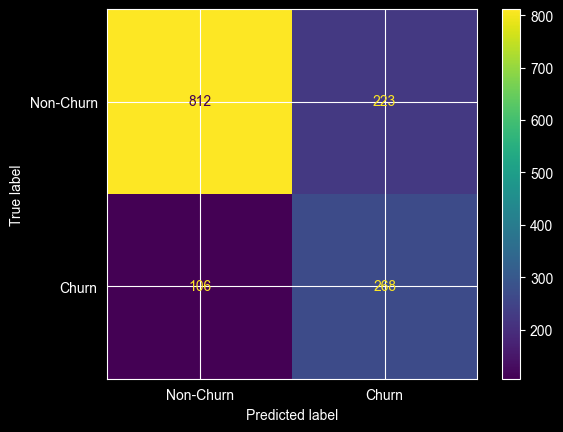

In [44]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, y_pred), display_labels=["Non-Churn", "Churn"]).plot()
plt.show()

In [45]:
y_scores_rf = best_rf.predict_proba(X_test)[:, 1]
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(Y_test, y_scores_rf)

### Feature Importance

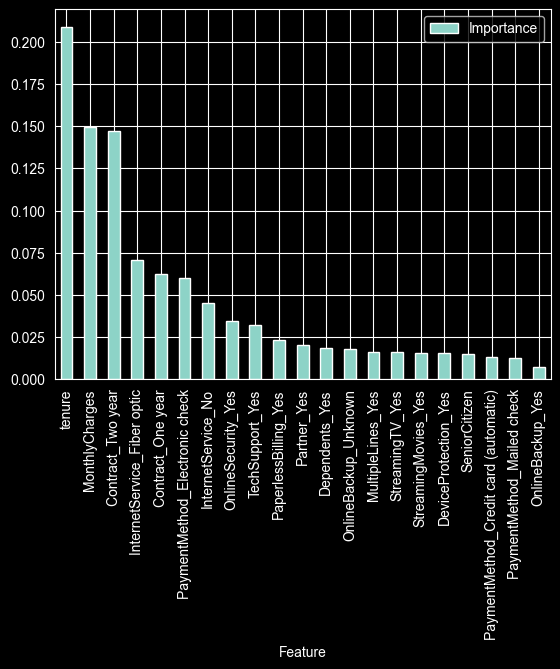

In [46]:
# Get importance
importance = best_rf.best_estimator_.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance}).sort_values(
    'Importance', ascending=False)

feature_importance.plot.bar(x='Feature', y='Importance')

Tenure, subscription price, contract modality are the main features impacting churn.

## XGBoost

In [47]:
parameters = {"learning_rate": [0.05, 0.1, 0.15], "n_estimators": [60, 80, 100, 120], "max_depth": [None, 3, 5, 10, 20]}

# Compute the scale_pos_weight
scale_pos_weight = (Y_train == 0).sum() / (Y_train == 1).sum()
best_xgb = GridSearchCV(estimator=XGBClassifier(random_state=rm_state, scale_pos_weight=scale_pos_weight),
                        param_grid=parameters, n_jobs=-1, scoring="f1", cv=5)
best_xgb.fit(X_train, Y_train)

print(best_xgb.best_params_)
print(best_xgb.best_score_)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 80}
0.6308412107717029


In [48]:
y_pred = best_xgb.predict(X_test)
y_pred_train = best_xgb.predict(X_train)

In [49]:
print(f"Performance on train set : \n {classification_report(Y_train, y_pred_train)}")
print(f"Performance on test set : \n {classification_report(Y_test, y_pred)}")

Performance on train set : 
               precision    recall  f1-score   support

           0       0.93      0.74      0.82      4139
           1       0.54      0.84      0.65      1495

    accuracy                           0.76      5634
   macro avg       0.73      0.79      0.74      5634
weighted avg       0.82      0.76      0.78      5634

Performance on test set : 
               precision    recall  f1-score   support

           0       0.91      0.74      0.81      1035
           1       0.52      0.80      0.63       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.77      1409



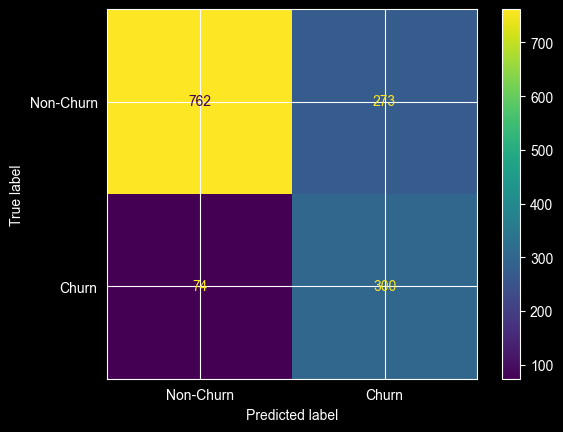

In [50]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, y_pred), display_labels=["Non-Churn", "Churn"]).plot()
plt.show()

In [51]:
y_scores_xgb = best_xgb.predict_proba(X_test)[:, 1]
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(Y_test, y_scores_xgb)

### Feature importance

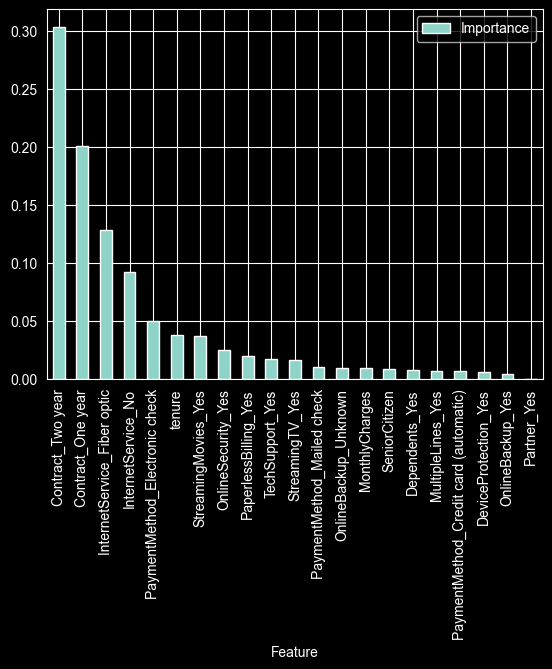

In [52]:
# Get importance
importance = best_xgb.best_estimator_.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance}).sort_values(
    'Importance', ascending=False)

feature_importance.plot.bar(x='Feature', y='Importance')

Feature importance is similar to random forest, although the importance of tenure is reduced, and the feature importance of "payment by electronic check" is increased.

# Models comparison

## Precision / Recall curves

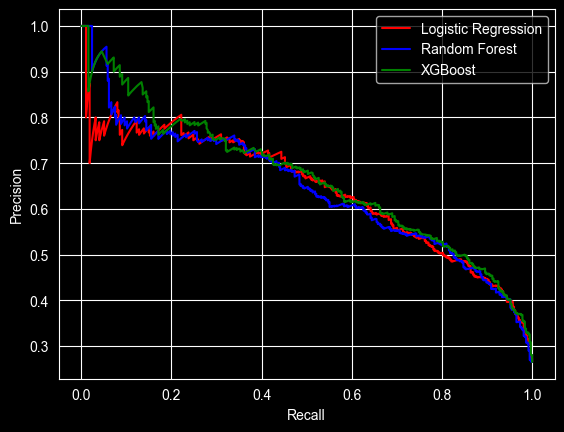

In [53]:
plt.plot(recall_lr, precision_lr, label="Logistic Regression", color="red")
plt.plot(recall_rf, precision_rf, label="Random Forest", color="blue")
plt.plot(recall_xgb, precision_xgb, label="XGBoost", color="green")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

## ROC curves

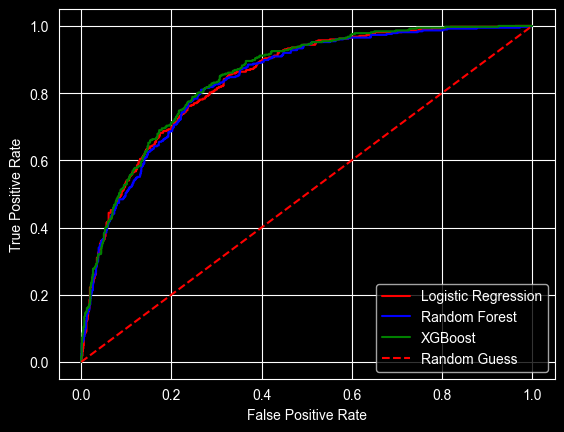

In [54]:
fpr_lr, tpr_lr, _ = roc_curve(Y_test, y_scores_lr)
fpr_rf, tpr_rf, _ = roc_curve(Y_test, y_scores_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(Y_test, y_scores_xgb)
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression", color="red")
plt.plot(fpr_rf, tpr_rf, label="Random Forest", color="blue")
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost", color="green")
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Recommandations to reduce Churn

- Fiber optic is closely related to churn: verify the quality of this service, as well as price alignment with competitors
- Encourage longer contract modalities
- investigate Paperless Billing and Electronic Check as these elements are correlated with churn

# Next steps

XGBoost predict churn with precision of approximately 82%, which is good but can be improved.

Deleting features of lesser importance or combining them into a single feature (example: "Number of options" is the sum of all the options) does not significantly improve the model performance. Other solutions exist:


- Gather more data points
- Gather more predictive features: detail information about predictive features (such as monthly charges, tenure, etc.), get additional information on less predictive features

Try other classification algorithms?
